# **Step 1: Import Necessary Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from collections import Counter, defaultdict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import json
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# **Step 2: Data Preparation**

## **2.1 Data Loading**

In [ ]:
print("="*80)
print("LOADING AND ANALYZING DATASET")
print("="*80)

json_path = "/content/drive/MyDrive/vqa-rad/qa.json"
img_folder = "/content/drive/MyDrive/vqa-rad/images"

with open(json_path, "r") as f:
    data = json.load(f)

print(f"\n✓ Loaded {len(data)} QA pairs from dataset")

LOADING AND ANALYZING DATASET

✓ Loaded 2248 QA pairs from dataset


## **2.2 Dataset Distribution**

In [ ]:
print("\n" + "="*80)
print("DATASET DISTRIBUTION ANALYSIS")
print("="*80)

# Analyze answer types
answer_type_counts = Counter([item["answer_type"].strip().upper() for item in data])
print("\n1. Answer Type Distribution:")
for ans_type, count in sorted(answer_type_counts.items()):
    pct = count / len(data) * 100
    print(f"   {ans_type:10s}: {count:4d} ({pct:5.2f}%)")

# Analyze question types
question_type_counts = Counter([item["question_type"].split(",")[0].strip() for item in data])
print("\n2. Question Type Distribution:")
for q_type, count in sorted(question_type_counts.items(), key=lambda x: -x[1])[:10]:
    pct = count / len(data) * 100
    print(f"   {q_type:20s}: {count:4d} ({pct:5.2f}%)")

# Analyze unique images
unique_images = set([item["image_name"] for item in data])
print(f"\n3. Unique Images: {len(unique_images)}")
print(f"   Average questions per image: {len(data) / len(unique_images):.2f}")

# Answer distribution for closed-ended
closed_answers = [str(item["answer"]).strip().lower()
                  for item in data if item["answer_type"].strip().upper() == "CLOSED"]
closed_counter = Counter(closed_answers)
print("\n4. Closed-Ended Answer Distribution:")
yes_count = sum(v for k, v in closed_counter.items() if k in ["yes", "y", "true", "present"])
no_count = sum(v for k, v in closed_counter.items() if k not in ["yes", "y", "true", "present"])
total_closed = yes_count + no_count
print(f"   YES: {yes_count:4d} ({yes_count/total_closed*100:5.2f}%)")
print(f"   NO:  {no_count:4d} ({no_count/total_closed*100:5.2f}%)")

# Top open-ended answers
open_answers = [str(item["answer"]).strip().lower()
                for item in data if item["answer_type"].strip().upper() == "OPEN"]
open_counter = Counter(open_answers)
print("\n5. Top 10 Open-Ended Answers:")
for ans, count in open_counter.most_common(10):
    pct = count / len(open_answers) * 100
    print(f"   {ans:20s}: {count:4d} ({pct:5.2f}%)")


DATASET DISTRIBUTION ANALYSIS

1. Answer Type Distribution:
   CLOSED    : 1299 (57.78%)
   OPEN      :  949 (42.22%)

2. Question Type Distribution:
   PRES                :  812 (36.12%)
   POS                 :  324 (14.41%)
   ABN                 :  205 ( 9.12%)
   OTHER               :  194 ( 8.63%)
   MODALITY            :  185 ( 8.23%)
   SIZE                :  175 ( 7.78%)
   PLANE               :  120 ( 5.34%)
   ATTRIB              :   92 ( 4.09%)
   ORGAN               :   59 ( 2.62%)
   COLOR               :   54 ( 2.40%)

3. Unique Images: 314
   Average questions per image: 7.16

4. Closed-Ended Answer Distribution:
   YES:  587 (45.19%)
   NO:   712 (54.81%)

5. Top 10 Open-Ended Answers:
   axial               :   42 ( 4.43%)
   right               :   23 ( 2.42%)
   left                :   15 ( 1.58%)
   brain               :   13 ( 1.37%)
   ct                  :   11 ( 1.16%)
   pa                  :   11 ( 1.16%)
   fat                 :    9 ( 0.95%)
   x-ray     

## **2.3 Sample Data**

In [ ]:
print("\n" + "="*80)
print("DATASET SAMPLES")
print("="*80)

print("\nSample QA Pairs:")
print("-" * 80)
for i, item in enumerate(data[:5], 1):
    print(f"\n{i}. Image: {item['image_name']}")
    print(f"   Question: {item['question']}")
    print(f"   Answer: {item['answer']}")
    print(f"   Type: {item['answer_type']} | Category: {item['question_type']}")


DATASET SAMPLES

Sample QA Pairs:
--------------------------------------------------------------------------------

1. Image: synpic54610.jpg
   Question: Are regions of the brain infarcted?
   Answer: Yes
   Type: CLOSED | Category: PRES

2. Image: synpic29265.jpg
   Question: Are the lungs normal appearing?
   Answer: No
   Type: CLOSED | Category: ABN

3. Image: synpic29265.jpg
   Question: Is there evidence of a pneumothorax
   Answer: No
   Type: CLOSED | Category: PRES

4. Image: synpic28602.jpg
   Question: What type of imaging does this not represent?
   Answer: ultrasound
   Type: OPEN | Category: MODALITY

5. Image: synpic29265.jpg
   Question: Is this a MRI of the chest?
   Answer: no
   Type: CLOSED | Category: MODALITY


## **2.4 Tokenization & Vocabulary**

In [ ]:
print("\n" + "="*80)
print("BUILDING VOCABULARY")
print("="*80)

def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = text.split()
    return tokens

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

def build_vocab(questions, min_freq=1):
    counter = Counter()
    for q in questions:
        tokens = simple_tokenize(q)
        counter.update(tokens)

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab, counter

def encode_question(question, vocab, max_len):
    tokens = simple_tokenize(question)
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens]
    ids = ids[:max_len]

    while len(ids) < max_len:
        ids.append(vocab[PAD_TOKEN])

    return torch.tensor(ids, dtype=torch.long)

def build_open_answer_vocab(data, top_k=100):
    open_answers = [
        str(item["answer"]).strip().lower()
        for item in data
        if item["answer_type"].strip().upper() == "OPEN"
    ]

    counter = Counter(open_answers)
    topk_answers = [ans for ans, _ in counter.most_common(top_k)]

    open_ans2id = {ans: i for i, ans in enumerate(topk_answers)}
    open_ans2id["OTHER_OPEN"] = len(open_ans2id)

    id2open_ans = {i: a for a, i in open_ans2id.items()}
    return open_ans2id, id2open_ans, counter

all_questions = [item["question"] for item in data]
vocab, word_counter = build_vocab(all_questions, min_freq=1)
open_ans2id, id2open_ans, open_ans_counter = build_open_answer_vocab(data, top_k=100)
closed_ans2id = {"yes": 0, "no": 1}

print(f"\n✓ Vocabulary size: {len(vocab)}")
print(f"✓ Top-K OPEN answer classes: {len(open_ans2id)}")
print(f"\nTop 10 most common question words:")
for word, count in word_counter.most_common(10):
    print(f"   {word:15s}: {count:4d}")


BUILDING VOCABULARY

✓ Vocabulary size: 1191
✓ Top-K OPEN answer classes: 101

Top 10 most common question words:
   the            : 1740
   is             : 1519
   what           :  575
   this           :  571
   in             :  529
   of             :  437
   there          :  432
   image          :  424
   are            :  323
   a              :  273


## **2.5 DataLoader Construction**

In [ ]:
class VQARADDataset(Dataset):
    def __init__(self, data, img_folder, vocab, closed_ans2id, open_ans2id, max_q_len, transform=None):
        self.data = data
        self.img_folder = img_folder
        self.vocab = vocab
        self.closed_ans2id = closed_ans2id
        self.open_ans2id = open_ans2id
        self.max_q_len = max_q_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load & process image
        img_path = os.path.join(self.img_folder, item["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Encode question
        q_ids = encode_question(item["question"], self.vocab, self.max_q_len)

        # Process answer
        answer = str(item["answer"]).strip().lower()
        ans_type = item["answer_type"].strip().upper()

        # Closed answer space
        if ans_type == "CLOSED":
            if answer in ["yes", "y", "true", "present"]:
                answer = "yes"
            else:
                answer = "no"
            ans_label = self.closed_ans2id[answer]
            ans_space = 0

        # Opened answer space
        else:
            ans_label = self.open_ans2id.get(answer, self.open_ans2id["OTHER_OPEN"])
            ans_space = 1

        # Convert label to tensor
        ans_label = torch.tensor(ans_label, dtype=torch.long)

        # Metadata
        meta = {
            "answer_type": item["answer_type"],
            "question_type": item["question_type"],
            "answer_text": answer
        }

        return image, q_ids, ans_label, ans_space, meta

# **Step 3: Model Architecture (CNN Based VQA Model)**

## **3.1 Text Embedding (Word Representation Layer)**

In [ ]:
class TextEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q_ids):
        x = self.embedding(q_ids)
        x = self.layer_norm(x)
        return self.dropout(x)

## **3.2 Text CNN (Question Encoder)**

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, embed_dim, num_filters, kernel_sizes, dropout=0.2):
        super().__init__()

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=k,
                padding=k//2
            )
            for k in kernel_sizes
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters) for _ in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings):
        x = embeddings.permute(0, 2, 1)

        conv_outputs = []
        for conv, bn in zip(self.convs, self.batch_norms):
            c = conv(x)
            c = bn(c)
            c = torch.relu(c)
            pooled = torch.max(c, dim=2)[0]
            conv_outputs.append(pooled)

        text_features = torch.cat(conv_outputs, dim=1)
        return self.dropout(text_features)

## **3.3 Image Encoder (Visual Feature Extractor)**

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, feature_dim=768, freeze_backbone=False):
        super().__init__()

        # Use EfficientNet-B0 for better performance
        from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
        effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for param in effnet.parameters():
                param.requires_grad = False
        else:
            # Only freeze early layers
            for i, (name, param) in enumerate(effnet.named_parameters()):
                if i < 100:  # Freeze first 100 layers
                    param.requires_grad = False

        # Remove classifier
        self.backbone = nn.Sequential(*list(effnet.children())[:-1])

        # Adaptive pooling
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Projection with residual connection
        self.proj = nn.Sequential(
            nn.Linear(1280, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(feature_dim, feature_dim),
            nn.LayerNorm(feature_dim)
        )

    def forward(self, images):
        x = self.backbone(images)
        x = self.pool(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.proj(x)
        return x

## **3.4 Multi Head Attention Fusion (Multimodal Fusion)**

In [ ]:
class MultiHeadAttentionFusion(nn.Module):
    def __init__(self, img_dim, text_dim, hidden_dim=768, num_heads=8):
        super().__init__()
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, img_feat, text_feat):
        # Project to same dimension
        img_h = self.img_proj(img_feat).unsqueeze(1)  # [B, 1, hidden]
        text_h = self.text_proj(text_feat).unsqueeze(1)  # [B, 1, hidden]

        # Concatenate for cross-attention
        combined = torch.cat([img_h, text_h], dim=1)  # [B, 2, hidden]

        # Self-attention
        attn_output, _ = self.multihead_attn(combined, combined, combined)

        # Pool and normalize
        fused = attn_output.mean(dim=1)  # [B, hidden]
        fused = self.norm(fused + img_h.squeeze(1) + text_h.squeeze(1))  # Residual
        fused = self.dropout(fused)

        return fused

## **3.5 VQAModel (Full Multimodal Network)**

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_filters,
        kernel_sizes,
        num_closed_answers,
        num_open_answers,
        hidden_dim=768
    ):
        super().__init__()

        self.text_embedding = TextEmbedding(vocab_size, embed_dim, dropout=0.2)
        self.text_cnn = TextCNN(embed_dim, num_filters, kernel_sizes, dropout=0.2)

        self.image_encoder = ImageEncoder(feature_dim=hidden_dim, freeze_backbone=False)

        image_feat_dim = hidden_dim
        text_feat_dim = num_filters * len(kernel_sizes)

        # Multi-head attention fusion
        self.attention_fusion = MultiHeadAttentionFusion(
            image_feat_dim, text_feat_dim, hidden_dim=hidden_dim, num_heads=8
        )

        # Shared layers with residual connections
        self.shared = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Separate heads with batch normalization
        self.closed_answer_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, num_closed_answers)
        )

        self.open_answer_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, num_open_answers)
        )

    def forward(self, images, q_ids):
        img_feat = self.image_encoder(images)
        embeds = self.text_embedding(q_ids)
        text_feat = self.text_cnn(embeds)

        # Multi-head attention fusion
        fused_feat = self.attention_fusion(img_feat, text_feat)

        # Shared representation
        shared_feat = self.shared(fused_feat) + fused_feat  # Residual connection

        # Task-specific heads
        closed_logits = self.closed_answer_head(shared_feat)
        open_logits = self.open_answer_head(shared_feat)

        return closed_logits, open_logits

# **Step 4: Model Evaluation**

In [ ]:
# Unified metrics for both CNN and Generative models

class UnifiedPerformanceMetrics:
    def __init__(self):
        self.reset()

    def reset(self):
        self.all_preds = []
        self.all_labels = []
        self.all_spaces = []
        self.all_answer_types = []
        self.all_question_types = []
        self.all_confidences = []

    def update(self, preds, labels, spaces, metas, confidences=None):
        self.all_preds.extend(preds if isinstance(preds, list) else preds.cpu().numpy())
        self.all_labels.extend(labels if isinstance(labels, list) else labels.cpu().numpy())
        self.all_spaces.extend(spaces if isinstance(spaces, list) else spaces.cpu().numpy())
        self.all_answer_types.extend(metas["answer_type"] if isinstance(metas, dict) else [m["answer_type"] for m in metas])
        self.all_question_types.extend(metas["question_type"] if isinstance(metas, dict) else [m["question_type"] for m in metas])

        if confidences is not None:
            self.all_confidences.extend(confidences if isinstance(confidences, list) else confidences.cpu().numpy())

    def compute(self):
        preds = np.array(self.all_preds)
        labels = np.array(self.all_labels)
        spaces = np.array(self.all_spaces)

        # Overall metrics
        overall_acc = (preds == labels).mean() * 100

        # By answer type
        type_metrics = {}
        for ans_type in ["CLOSED", "OPEN"]:
            mask = np.array([t.strip().upper() == ans_type for t in self.all_answer_types])
            if mask.sum() > 0:
                correct = (preds[mask] == labels[mask]).sum()
                total = mask.sum()
                acc = correct / total * 100

                # Calculate precision, recall, F1 for this type
                if ans_type == "CLOSED":
                    prec, rec, f1, _ = precision_recall_fscore_support(
                        labels[mask], preds[mask], average='weighted', zero_division=0
                    )
                else:
                    prec, rec, f1, _ = precision_recall_fscore_support(
                        labels[mask], preds[mask], average='macro', zero_division=0
                    )

                type_metrics[ans_type] = {
                    "accuracy": acc,
                    "correct": int(correct),
                    "total": int(total),
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }

        # By question type
        question_metrics = defaultdict(lambda: {"correct": 0, "total": 0})
        for pred, label, q_type in zip(preds, labels, self.all_question_types):
            q_type_main = q_type.split(",")[0].strip()
            question_metrics[q_type_main]["total"] += 1
            if pred == label:
                question_metrics[q_type_main]["correct"] += 1

        # Add accuracy to question metrics
        for q_type in question_metrics:
            question_metrics[q_type]["accuracy"] = (
                question_metrics[q_type]["correct"] / question_metrics[q_type]["total"] * 100
            )

        # Confidence metrics
        confidence_metrics = None
        if len(self.all_confidences) > 0:
            confidences = np.array(self.all_confidences)
            confidence_metrics = {
                "mean": float(np.mean(confidences)),
                "std": float(np.std(confidences)),
                "median": float(np.median(confidences))
            }

        return {
            "overall_accuracy": overall_acc,
            "type_metrics": type_metrics,
            "question_metrics": dict(question_metrics),
            "confidence_metrics": confidence_metrics,
            "predictions": preds,
            "labels": labels,
            "spaces": spaces
        }

    # Print comprehensive results
    def print_results(self, model_name="Model"):
        results = self.compute()

        print("\n" + "="*80)
        print(f"{model_name.upper()} - EVALUATION RESULTS")
        print("="*80)

        print(f"\nOverall Accuracy: {results['overall_accuracy']:.2f}%")

        print("\n" + "-"*80)
        print("Performance by Answer Type:")
        print("-"*80)
        print(f"{'Type':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Count'}")
        print("-"*80)
        for ans_type in sorted(results["type_metrics"].keys()):
            m = results["type_metrics"][ans_type]
            print(f"{ans_type:<10} {m['accuracy']:>6.2f}%      "
                  f"{m['precision']:>6.4f}       {m['recall']:>6.4f}       "
                  f"{m['f1']:>6.4f}       {m['correct']}/{m['total']}")

        print("\n" + "-"*80)
        print("Performance by Question Type:")
        print("-"*80)
        print(f"{'Question Type':<25} {'Accuracy':<12} {'Correct/Total'}")
        print("-"*80)
        for q_type in sorted(results["question_metrics"].keys(), key=lambda x: -results["question_metrics"][x]["accuracy"]):
            m = results["question_metrics"][q_type]
            print(f"{q_type:<25} {m['accuracy']:>6.2f}%      {m['correct']}/{m['total']}")

        if results["confidence_metrics"]:
            print("\n" + "-"*80)
            print("Confidence Metrics:")
            print("-"*80)
            cm = results["confidence_metrics"]
            print(f"Mean:   {cm['mean']:.4f}")
            print(f"Median: {cm['median']:.4f}")
            print(f"Std:    {cm['std']:.4f}")

        return results

# **Step 5: Training Setup**

In [ ]:
print("\n" + "="*80)
print("PREPARING TRAINING & VALIDATION SPLITS")
print("="*80)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✓ Device: {device}")

# Data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Stratified split based on answer type
train_data, val_data = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=[item["answer_type"] for item in data]
)

print(f"\n✓ Train samples: {len(train_data)}")
print(f"✓ Validation samples: {len(val_data)}")

# Print split distribution
train_types = Counter([item["answer_type"].strip().upper() for item in train_data])
val_types = Counter([item["answer_type"].strip().upper() for item in val_data])

print("\nTrain split distribution:")
for ans_type in sorted(train_types.keys()):
    print(f"   {ans_type}: {train_types[ans_type]} ({train_types[ans_type]/len(train_data)*100:.2f}%)")

print("\nValidation split distribution:")
for ans_type in sorted(val_types.keys()):
    print(f"   {ans_type}: {val_types[ans_type]} ({val_types[ans_type]/len(val_data)*100:.2f}%)")

# Create datasets
train_dataset = VQARADDataset(
    data=train_data,
    img_folder=img_folder,
    vocab=vocab,
    closed_ans2id=closed_ans2id,
    open_ans2id=open_ans2id,
    max_q_len=30,
    transform=train_transform
)

val_dataset = VQARADDataset(
    data=val_data,
    img_folder=img_folder,
    vocab=vocab,
    closed_ans2id=closed_ans2id,
    open_ans2id=open_ans2id,
    max_q_len=30,
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


PREPARING TRAINING & VALIDATION SPLITS

✓ Device: cuda

✓ Train samples: 1798
✓ Validation samples: 450

Train split distribution:
   CLOSED: 1039 (57.79%)
   OPEN: 759 (42.21%)

Validation split distribution:
   CLOSED: 260 (57.78%)
   OPEN: 190 (42.22%)


# **Step 6: Model Initialization**

In [ ]:
print("INITIALIZING MODEL")
print("="*80)

embed_dim = 256
num_filters = 256
kernel_sizes = [2, 3, 4, 5]
hidden_dim = 768

model = VQAModel(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    num_closed_answers=len(closed_ans2id),
    num_open_answers=len(open_ans2id),
    hidden_dim=hidden_dim
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


INITIALIZING MODEL
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 51.5MB/s]



✓ Model initialized
   Total parameters: 12,367,203
   Trainable parameters: 12,097,583


# **Step 7: Training Configuration**

In [ ]:
print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)

# Weighted loss for imbalanced classes
closed_weight = torch.tensor([1.0, 1.0]).to(device)  # Adjust based on data
open_weight = None  # Let PyTorch handle it

criterion_closed = nn.CrossEntropyLoss(weight=closed_weight)
criterion_open = nn.CrossEntropyLoss()

# AdamW optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0003,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Cosine annealing with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2, eta_min=1e-6
)

# Training hyperparameters
num_epochs = 25
lambda_open = 1.0  # Equal weight for open-ended
early_stopping_patience = 7
best_val_acc = 0
patience_counter = 0
best_model_path = '/content/drive/MyDrive/best_vqa_model_enhanced.pth'

print(f"\n✓ Optimizer: AdamW (lr=0.0003, weight_decay=0.01)")
print(f"✓ Scheduler: CosineAnnealingWarmRestarts")
print(f"✓ Epochs: {num_epochs}")
print(f"✓ Early stopping patience: {early_stopping_patience}")
print(f"✓ Batch size: 32")
print(f"✓ Loss weights - Closed: 1.0, Open: {lambda_open}")



TRAINING CONFIGURATION

✓ Optimizer: AdamW (lr=0.0003, weight_decay=0.01)
✓ Scheduler: CosineAnnealingWarmRestarts
✓ Epochs: 25
✓ Early stopping patience: 7
✓ Batch size: 32
✓ Loss weights - Closed: 1.0, Open: 1.0


# **Step 8: Training Loop**

In [ ]:
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

train_losses = []
val_losses = []
val_accuracies = []
learning_rates = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for images, q_ids, ans_labels, ans_space, _ in pbar:
        images = images.to(device)
        q_ids = q_ids.to(device)
        ans_labels = ans_labels.to(device)
        ans_space = ans_space.to(device)

        optimizer.zero_grad()
        closed_logits, open_logits = model(images, q_ids)

        mask_closed = (ans_space == 0)
        mask_open = (ans_space == 1)

        zero = torch.tensor(0.0, device=device)
        loss_closed = criterion_closed(closed_logits[mask_closed], ans_labels[mask_closed]) if mask_closed.any() else zero
        loss_open = criterion_open(open_logits[mask_open], ans_labels[mask_open]) if mask_open.any() else zero

        loss = loss_closed + lambda_open * loss_open
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Validation
    model.eval()
    running_val_loss = 0.0
    metrics = UnifiedPerformanceMetrics()

    with torch.no_grad():
        for images, q_ids, ans_labels, ans_space, metas in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            images = images.to(device)
            q_ids = q_ids.to(device)
            ans_labels = ans_labels.to(device)
            ans_space = ans_space.to(device)

            closed_logits, open_logits = model(images, q_ids)

            mask_closed = (ans_space == 0)
            mask_open = (ans_space == 1)

            zero = torch.tensor(0.0, device=device)
            loss_closed = criterion_closed(closed_logits[mask_closed], ans_labels[mask_closed]) if mask_closed.any() else zero
            loss_open = criterion_open(open_logits[mask_open], ans_labels[mask_open]) if mask_open.any() else zero

            val_loss = loss_closed + lambda_open * loss_open
            running_val_loss += val_loss.item()

            preds = torch.zeros_like(ans_labels)
            preds[ans_space == 0] = closed_logits[ans_space == 0].argmax(dim=1)
            preds[ans_space == 1] = open_logits[ans_space == 1].argmax(dim=1)

            # metas is already a dict with lists as values from DataLoader collation
            metrics.update(preds, ans_labels, ans_space, metas)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    results = metrics.compute()
    val_acc = results["overall_accuracy"]
    val_accuracies.append(val_acc)

    epoch_time = time.time() - start_time

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - LR: {current_lr:.6f}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    for ans_type in sorted(results["type_metrics"].keys()):
        m = results["type_metrics"][ans_type]
        print(f"  {ans_type}: {m['accuracy']:.2f}% ({m['correct']}/{m['total']}) | "
              f"P: {m['precision']:.3f} R: {m['recall']:.3f} F1: {m['f1']:.3f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'vocab': vocab,
            'open_ans2id': open_ans2id,
            'id2open_ans': id2open_ans,
            'closed_ans2id': closed_ans2id
        }, best_model_path)
        print(f"✓ Best model saved! New best accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        if patience_counter >= early_stopping_patience:
            print(f"\n✗ Early stopping triggered at epoch {epoch+1}")
            break

    scheduler.step()
    print()

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


STARTING TRAINING


Epoch 1/25 [Train]: 100%|██████████| 57/57 [01:26<00:00,  1.52s/it, loss=3.5191]



Epoch 1/25 - Time: 90.59s - LR: 0.000300
Train Loss: 3.5907 | Val Loss: 3.1360 | Val Acc: 50.89%
  CLOSED: 45.00% (117/260) | P: 0.606 R: 0.450 F1: 0.330
  OPEN: 58.95% (112/190) | P: 0.012 R: 0.020 F1: 0.015
✓ Best model saved! New best accuracy: 50.89%



Epoch 2/25 [Train]: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s, loss=3.8331]



Epoch 2/25 - Time: 29.94s - LR: 0.000271
Train Loss: 3.2960 | Val Loss: 2.9366 | Val Acc: 62.22%
  CLOSED: 61.54% (160/260) | P: 0.680 R: 0.615 F1: 0.607
  OPEN: 63.16% (120/190) | P: 0.033 R: 0.041 F1: 0.036
✓ Best model saved! New best accuracy: 62.22%



Epoch 3/25 [Train]: 100%|██████████| 57/57 [00:25<00:00,  2.21it/s, loss=3.2853]



Epoch 3/25 - Time: 29.54s - LR: 0.000197
Train Loss: 2.8808 | Val Loss: 2.6515 | Val Acc: 69.11%
  CLOSED: 73.46% (191/260) | P: 0.737 R: 0.735 F1: 0.727
  OPEN: 63.16% (120/190) | P: 0.029 R: 0.041 F1: 0.034
✓ Best model saved! New best accuracy: 69.11%



Epoch 4/25 [Train]: 100%|██████████| 57/57 [00:25<00:00,  2.23it/s, loss=0.5537]



Epoch 4/25 - Time: 30.50s - LR: 0.000104
Train Loss: 2.3648 | Val Loss: 2.6869 | Val Acc: 66.44%
  CLOSED: 68.08% (177/260) | P: 0.680 R: 0.681 F1: 0.681
  OPEN: 64.21% (122/190) | P: 0.062 R: 0.073 F1: 0.067
  No improvement. Patience: 1/7



Epoch 5/25 [Train]: 100%|██████████| 57/57 [00:21<00:00,  2.67it/s, loss=5.2235]



Epoch 5/25 - Time: 25.84s - LR: 0.000030
Train Loss: 2.1035 | Val Loss: 2.6690 | Val Acc: 68.89%
  CLOSED: 72.69% (189/260) | P: 0.732 R: 0.727 F1: 0.728
  OPEN: 63.68% (121/190) | P: 0.058 R: 0.079 F1: 0.065
  No improvement. Patience: 2/7



Epoch 6/25 [Train]: 100%|██████████| 57/57 [00:21<00:00,  2.60it/s, loss=1.7604]



Epoch 6/25 - Time: 25.77s - LR: 0.000300
Train Loss: 2.1573 | Val Loss: 2.7287 | Val Acc: 66.67%
  CLOSED: 68.08% (177/260) | P: 0.701 R: 0.681 F1: 0.682
  OPEN: 64.74% (123/190) | P: 0.070 R: 0.076 F1: 0.066
  No improvement. Patience: 3/7



Epoch 7/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s, loss=1.8503]



Epoch 7/25 - Time: 26.10s - LR: 0.000293
Train Loss: 1.9060 | Val Loss: 2.9531 | Val Acc: 67.11%
  CLOSED: 70.00% (182/260) | P: 0.737 R: 0.700 F1: 0.700
  OPEN: 63.16% (120/190) | P: 0.050 R: 0.076 F1: 0.056
  No improvement. Patience: 4/7



Epoch 8/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.54it/s, loss=0.8701]



Epoch 8/25 - Time: 26.32s - LR: 0.000271
Train Loss: 1.5228 | Val Loss: 2.6248 | Val Acc: 70.89%
  CLOSED: 75.77% (197/260) | P: 0.756 R: 0.758 F1: 0.756
  OPEN: 64.21% (122/190) | P: 0.091 R: 0.119 F1: 0.094
✓ Best model saved! New best accuracy: 70.89%



Epoch 9/25 [Train]: 100%|██████████| 57/57 [00:25<00:00,  2.21it/s, loss=1.7182]



Epoch 9/25 - Time: 30.54s - LR: 0.000238
Train Loss: 1.2297 | Val Loss: 2.9076 | Val Acc: 64.22%
  CLOSED: 69.62% (181/260) | P: 0.741 R: 0.696 F1: 0.695
  OPEN: 56.84% (108/190) | P: 0.074 R: 0.111 F1: 0.081
  No improvement. Patience: 1/7



Epoch 10/25 [Train]: 100%|██████████| 57/57 [00:21<00:00,  2.65it/s, loss=0.4541]



Epoch 10/25 - Time: 25.31s - LR: 0.000197
Train Loss: 0.9362 | Val Loss: 2.9902 | Val Acc: 67.33%
  CLOSED: 72.31% (188/260) | P: 0.729 R: 0.723 F1: 0.724
  OPEN: 60.53% (115/190) | P: 0.098 R: 0.115 F1: 0.102
  No improvement. Patience: 2/7



Epoch 11/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.57it/s, loss=1.2319]



Epoch 11/25 - Time: 26.01s - LR: 0.000150
Train Loss: 0.7381 | Val Loss: 3.3325 | Val Acc: 64.44%
  CLOSED: 74.62% (194/260) | P: 0.747 R: 0.746 F1: 0.746
  OPEN: 50.53% (96/190) | P: 0.127 R: 0.160 F1: 0.126
  No improvement. Patience: 3/7



Epoch 12/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s, loss=0.5149]



Epoch 12/25 - Time: 25.99s - LR: 0.000104
Train Loss: 0.6189 | Val Loss: 2.8741 | Val Acc: 69.56%
  CLOSED: 73.08% (190/260) | P: 0.737 R: 0.731 F1: 0.732
  OPEN: 64.74% (123/190) | P: 0.142 R: 0.159 F1: 0.142
  No improvement. Patience: 4/7



Epoch 13/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.57it/s, loss=1.2691]



Epoch 13/25 - Time: 25.91s - LR: 0.000063
Train Loss: 0.4180 | Val Loss: 2.9509 | Val Acc: 70.89%
  CLOSED: 75.77% (197/260) | P: 0.759 R: 0.758 F1: 0.758
  OPEN: 64.21% (122/190) | P: 0.161 R: 0.159 F1: 0.158
  No improvement. Patience: 5/7



Epoch 14/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.57it/s, loss=0.3532]



Epoch 14/25 - Time: 26.01s - LR: 0.000030
Train Loss: 0.3067 | Val Loss: 3.0814 | Val Acc: 70.89%
  CLOSED: 75.00% (195/260) | P: 0.753 R: 0.750 F1: 0.751
  OPEN: 65.26% (124/190) | P: 0.150 R: 0.157 F1: 0.150
  No improvement. Patience: 6/7



Epoch 15/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.54it/s, loss=0.0145]



Epoch 15/25 - Time: 26.18s - LR: 0.000008
Train Loss: 0.2468 | Val Loss: 3.0733 | Val Acc: 72.22%
  CLOSED: 77.69% (202/260) | P: 0.777 R: 0.777 F1: 0.777
  OPEN: 64.74% (123/190) | P: 0.153 R: 0.159 F1: 0.149
✓ Best model saved! New best accuracy: 72.22%



Epoch 16/25 [Train]: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s, loss=0.1641]



Epoch 16/25 - Time: 30.05s - LR: 0.000300
Train Loss: 0.6322 | Val Loss: 2.9563 | Val Acc: 67.56%
  CLOSED: 74.23% (193/260) | P: 0.746 R: 0.742 F1: 0.743
  OPEN: 58.42% (111/190) | P: 0.138 R: 0.163 F1: 0.141
  No improvement. Patience: 1/7



Epoch 17/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.57it/s, loss=0.1387]



Epoch 17/25 - Time: 26.25s - LR: 0.000298
Train Loss: 0.6279 | Val Loss: 3.1537 | Val Acc: 67.56%
  CLOSED: 74.23% (193/260) | P: 0.741 R: 0.742 F1: 0.741
  OPEN: 58.42% (111/190) | P: 0.088 R: 0.093 F1: 0.084
  No improvement. Patience: 2/7



Epoch 18/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.53it/s, loss=0.8019]



Epoch 18/25 - Time: 26.33s - LR: 0.000293
Train Loss: 0.5861 | Val Loss: 3.2263 | Val Acc: 67.33%
  CLOSED: 75.38% (196/260) | P: 0.758 R: 0.754 F1: 0.755
  OPEN: 56.32% (107/190) | P: 0.110 R: 0.116 F1: 0.104
  No improvement. Patience: 3/7



Epoch 19/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.53it/s, loss=0.2016]



Epoch 19/25 - Time: 26.46s - LR: 0.000284
Train Loss: 0.4985 | Val Loss: 3.4157 | Val Acc: 63.56%
  CLOSED: 70.77% (184/260) | P: 0.718 R: 0.708 F1: 0.709
  OPEN: 53.68% (102/190) | P: 0.142 R: 0.181 F1: 0.153
  No improvement. Patience: 4/7



Epoch 20/25 [Train]: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s, loss=0.0122]



Epoch 20/25 - Time: 26.35s - LR: 0.000271
Train Loss: 0.4563 | Val Loss: 3.3675 | Val Acc: 68.00%
  CLOSED: 72.31% (188/260) | P: 0.729 R: 0.723 F1: 0.724
  OPEN: 62.11% (118/190) | P: 0.169 R: 0.153 F1: 0.145
  No improvement. Patience: 5/7



Epoch 21/25 [Train]: 100%|██████████| 57/57 [00:21<00:00,  2.70it/s, loss=1.9942]



Epoch 21/25 - Time: 25.95s - LR: 0.000256
Train Loss: 0.4633 | Val Loss: 3.2253 | Val Acc: 65.78%
  CLOSED: 70.77% (184/260) | P: 0.723 R: 0.708 F1: 0.709
  OPEN: 58.95% (112/190) | P: 0.091 R: 0.087 F1: 0.089
  No improvement. Patience: 6/7



Epoch 22/25 [Train]: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s, loss=0.3032]
                                                                  


Epoch 22/25 - Time: 26.21s - LR: 0.000238
Train Loss: 0.3133 | Val Loss: 3.3079 | Val Acc: 65.78%
  CLOSED: 68.08% (177/260) | P: 0.715 R: 0.681 F1: 0.681
  OPEN: 62.63% (119/190) | P: 0.169 R: 0.171 F1: 0.162
  No improvement. Patience: 7/7

✗ Early stopping triggered at epoch 22

TRAINING COMPLETED
Best Validation Accuracy: 72.22%


# **Step 9: CNN Model Evaluation**

In [ ]:
print("\n" + "="*80)
print("FINAL CNN MODEL EVALUATION")
print("="*80)

# Load best model
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
final_cnn_metrics = UnifiedPerformanceMetrics()

with torch.no_grad():
    for images, q_ids, ans_labels, ans_space, metas in tqdm(val_loader, desc="Final Evaluation"):
        images = images.to(device)
        q_ids = q_ids.to(device)
        ans_labels = ans_labels.to(device)
        ans_space = ans_space.to(device)

        closed_logits, open_logits = model(images, q_ids)

        preds = torch.zeros_like(ans_labels)
        preds[ans_space == 0] = closed_logits[ans_space == 0].argmax(dim=1)
        preds[ans_space == 1] = open_logits[ans_space == 1].argmax(dim=1)

        # Get confidence scores (max probability)
        closed_probs = torch.softmax(closed_logits, dim=1)
        open_probs = torch.softmax(open_logits, dim=1)

        confidences = torch.zeros(len(ans_labels), device=device)
        confidences[ans_space == 0] = closed_probs[ans_space == 0].max(dim=1)[0]
        confidences[ans_space == 1] = open_probs[ans_space == 1].max(dim=1)[0]

        # metas is already a dict from DataLoader with custom collate_fn
        final_cnn_metrics.update(preds, ans_labels, ans_space, metas, confidences)

cnn_results = final_cnn_metrics.print_results("CNN Model")


FINAL CNN MODEL EVALUATION


Final Evaluation: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


CNN MODEL - EVALUATION RESULTS

Overall Accuracy: 72.22%

--------------------------------------------------------------------------------
Performance by Answer Type:
--------------------------------------------------------------------------------
Type       Accuracy     Precision    Recall       F1-Score     Count
--------------------------------------------------------------------------------
CLOSED      77.69%      0.7769       0.7769       0.7769       202/260
OPEN        64.74%      0.1529       0.1591       0.1485       123/190

--------------------------------------------------------------------------------
Performance by Question Type:
--------------------------------------------------------------------------------
Question Type             Accuracy     Correct/Total
--------------------------------------------------------------------------------
PLANE                      82.35%      14/17
COLOR                      81.82%      9/11
OTHER                      81.82%      27/3

# **Step 10: Generative AI Model Setup & Evaluation**

In [ ]:
print("\n" + "="*80)
print("GENERATIVE AI MODEL (GPT-4O) EVALUATION")
print("="*80)

import base64
from typing import Dict, List, Tuple
import openai
import time

class GenerativeAI_VQA:
    def __init__(self, api_key: str, model: str = "gpt-4o"):
        if not api_key:
            raise ValueError("API key is required! Please provide a valid OpenAI API key.")

        self.api_key = api_key
        self.model = model

        # Initialize OpenAI client
        try:
            openai.api_key = api_key
            self.client = openai.OpenAI(api_key=api_key)
            # Test API connection
            self.client.models.list()
            print(f"✓ GPT-4O initialized successfully")
            print(f"  Model: {self.model}")
        except Exception as e:
            raise RuntimeError(f"Failed to initialize OpenAI API: {e}")

        # Medical terminology mappings for answer normalization
        self.medical_synonyms = {
            'yes': ['yes', 'present', 'positive', 'true', 'y', 'detected', 'visible', 'shown'],
            'no': ['no', 'absent', 'negative', 'false', 'n', 'not detected', 'not visible', 'not shown', 'none'],
            'ct': ['ct', 'computed tomography', 'ct scan', 'cat scan'],
            'mri': ['mri', 'magnetic resonance imaging', 'mr', 'nmr'],
            'x-ray': ['x-ray', 'xray', 'radiograph', 'plain film'],
            'ultrasound': ['ultrasound', 'us', 'sonography', 'echo'],
            'axial': ['axial', 'transverse', 'horizontal'],
            'coronal': ['coronal', 'frontal'],
            'sagittal': ['sagittal', 'lateral', 'side']
        }


    # Create optimized prompt for medical VQA
    def create_medical_prompt(self, question: str, answer_type: str, question_type: str = None) -> str:
        base_instruction = """You are an expert radiologist analyzing medical images. Provide accurate, concise answers based on visual evidence."""

        # Add examples based on question type
        examples = ""
        if question_type:
            if "PRES" in question_type.upper():
                examples = "\nExamples:\nQ: Is there pneumonia present?\nA: yes\n\nQ: Is there a fracture visible?\nA: no"
            elif "PLANE" in question_type.upper():
                examples = "\nExamples:\nQ: What plane is shown?\nA: axial\n\nQ: In what plane is the image?\nA: coronal"
            elif "MODALITY" in question_type.upper():
                examples = "\nExamples:\nQ: What modality is shown?\nA: ct\n\nQ: What imaging technique was used?\nA: mri"

        # Format instruction based on answer type
        if answer_type == 'CLOSED':
            format_instruction = '\nAnswer with ONLY "yes" or "no". Do NOT provide explanations or additional text.'
        else:
            format_instruction = '\nAnswer with 1-3 words maximum using standard medical terminology. Be specific and concise.'

        return f"{base_instruction}\n{examples}\n{format_instruction}\n\nQuestion: {question}\n\nAnswer:"


    # Normalize model output to standard format
    def normalize_answer(self, answer: str, answer_type: str = None) -> str:
        answer = answer.lower().strip()

        # Remove common prefixes
        answer = answer.replace('the ', '').replace('a ', '').replace('an ', '')
        answer = answer.replace('.', '').replace(',', '').replace('!', '').replace('answer:', '')
        answer = answer.strip()

        # Limit to first 3 words for open-ended questions
        if len(answer.split()) > 3:
            answer = ' '.join(answer.split()[:3])

        # Map to standard medical terminology
        for standard, synonyms in self.medical_synonyms.items():
            if answer in synonyms or any(syn in answer for syn in synonyms):
                return standard

        return answer


    # Encode image to base64 string
    def encode_image(self, image_path: str) -> str:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')


    # Generate prediction for a VQA sample
    def predict(self, image_path: str, question: str, answer_type: str,
                question_type: str = None, temperature: float = 0.0) -> Tuple[str, float]:
        try:
            # Encode image
            base64_image = self.encode_image(image_path)

            # Create prompt
            prompt = self.create_medical_prompt(question, answer_type, question_type)

            # API call with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    response = self.client.chat.completions.create(
                        model=self.model,
                        messages=[{
                            "role": "user",
                            "content": [
                                {"type": "text", "text": prompt},
                                {
                                    "type": "image_url",
                                    "image_url": {
                                        "url": f"data:image/jpeg;base64,{base64_image}",
                                        "detail": "high"
                                    }
                                }
                            ]
                        }],
                        max_tokens=100,
                        temperature=temperature
                    )

                    # Extract prediction
                    prediction = response.choices[0].message.content.strip()

                    # Estimate confidence
                    confidence = self._estimate_confidence(prediction, response)

                    # Normalize answer
                    normalized_pred = self.normalize_answer(prediction, answer_type)

                    return normalized_pred, confidence

                except Exception as e:
                    if attempt == max_retries - 1:
                        raise e
                    # Wait before retry
                    time.sleep(2 ** attempt)  # Exponential backoff

        except Exception as e:
            print(f"\n✗ Error in GPT-4O prediction: {e}")
            raise


    # Estimate confidence score based on response characteristics
    def _estimate_confidence(self, response_text: str, response_obj) -> float:
        confidence = 0.7

        # Short, concise answers tend to be more confident
        if len(response_text.split()) <= 3:
            confidence += 0.15

        # Check for uncertainty markers
        uncertainty_markers = ['maybe', 'possibly', 'might', 'could', 'unclear', 'uncertain', 'appears']
        if not any(marker in response_text.lower() for marker in uncertainty_markers):
            confidence += 0.1

        # Penalize overly long responses
        if len(response_text.split()) > 10:
            confidence -= 0.2

        return min(max(confidence, 0.0), 1.0)


print("\nInitializing Generative AI Model...")

API_KEY = "YOUR_API_KEY_HERE"

# Initialize model
try:
    gpt4o_model = GenerativeAI_VQA(api_key=API_KEY, model="gpt-4o")
except Exception as e:
    print(f"\n✗ Failed to initialize GPT-4O: {e}")
    raise

# Evaluate on validation set
print(f"\n{'='*80}")
print("EVALUATING GPT-4O ON VALIDATION SET")
print(f"{'='*80}")

gen_metrics = UnifiedPerformanceMetrics()

# Set to None to evaluate on full validation set
MAX_EVAL_SAMPLES = None

eval_data = val_data[:MAX_EVAL_SAMPLES] if MAX_EVAL_SAMPLES else val_data

print(f"\nEvaluating on {len(eval_data)} samples...")
if MAX_EVAL_SAMPLES:
    print(f"⚠️  Limited evaluation - only using {MAX_EVAL_SAMPLES} samples")
else:
    print(f"✓ Full validation set evaluation")


for item in tqdm(eval_data, desc="Evaluating GPT-4O"):
    image_path = os.path.join(img_folder, item["image_name"])
    question = item["question"]
    answer_type = item["answer_type"].strip().upper()
    question_type = item["question_type"]

    # Get ground truth
    gt_answer = str(item["answer"]).strip().lower()
    if answer_type == "CLOSED":
        if gt_answer in ["yes", "y", "true", "present"]:
            gt_answer = "yes"
            gt_label = 0
        else:
            gt_answer = "no"
            gt_label = 1
        ans_space = 0
    else:
        gt_label = open_ans2id.get(gt_answer, open_ans2id["OTHER_OPEN"])
        ans_space = 1

    # Get prediction from GPT-4O
    try:
        pred_answer, confidence = gpt4o_model.predict(
            image_path, question, answer_type, question_type
        )

    except Exception as e:
        print(f"\n✗ Error on sample: {item['image_name']}")
        print(f"  Error: {e}")
        continue

    # Convert prediction to label
    if answer_type == "CLOSED":
        pred_label = 0 if pred_answer == "yes" else 1
    else:
        pred_label = open_ans2id.get(pred_answer, open_ans2id["OTHER_OPEN"])

    # Update metrics
    meta_dict = {
        "answer_type": [answer_type],
        "question_type": [question_type]
    }

    gen_metrics.update([pred_label], [gt_label], [ans_space], meta_dict, [confidence])

# Print results
gen_results = gen_metrics.print_results("Generative AI (GPT-4O)")


GENERATIVE AI MODEL (GPT-4O) EVALUATION

Initializing Generative AI Model...
✓ GPT-4O initialized successfully
  Model: gpt-4o

EVALUATING GPT-4O ON VALIDATION SET

Evaluating on 450 samples...
✓ Full validation set evaluation


Evaluating GPT-4O: 100%|██████████| 450/450 [06:44<00:00,  1.11it/s]


GENERATIVE AI (GPT-4O) - EVALUATION RESULTS

Overall Accuracy: 63.33%

--------------------------------------------------------------------------------
Performance by Answer Type:
--------------------------------------------------------------------------------
Type       Accuracy     Precision    Recall       F1-Score     Count
--------------------------------------------------------------------------------
CLOSED      61.92%      0.6440       0.6192       0.6202       161/260
OPEN        65.26%      0.1300       0.1633       0.1332       124/190

--------------------------------------------------------------------------------
Performance by Question Type:
--------------------------------------------------------------------------------
Question Type             Accuracy     Correct/Total
--------------------------------------------------------------------------------
PLANE                      94.12%      16/17
OTHER                      78.79%      26/33
ATTRIB                     72

# **Step 11: VQA Model Comparison (CNN vs GPT-4o)**


✓ Unified comparison saved to: /content/drive/MyDrive/unified_model_comparison.png


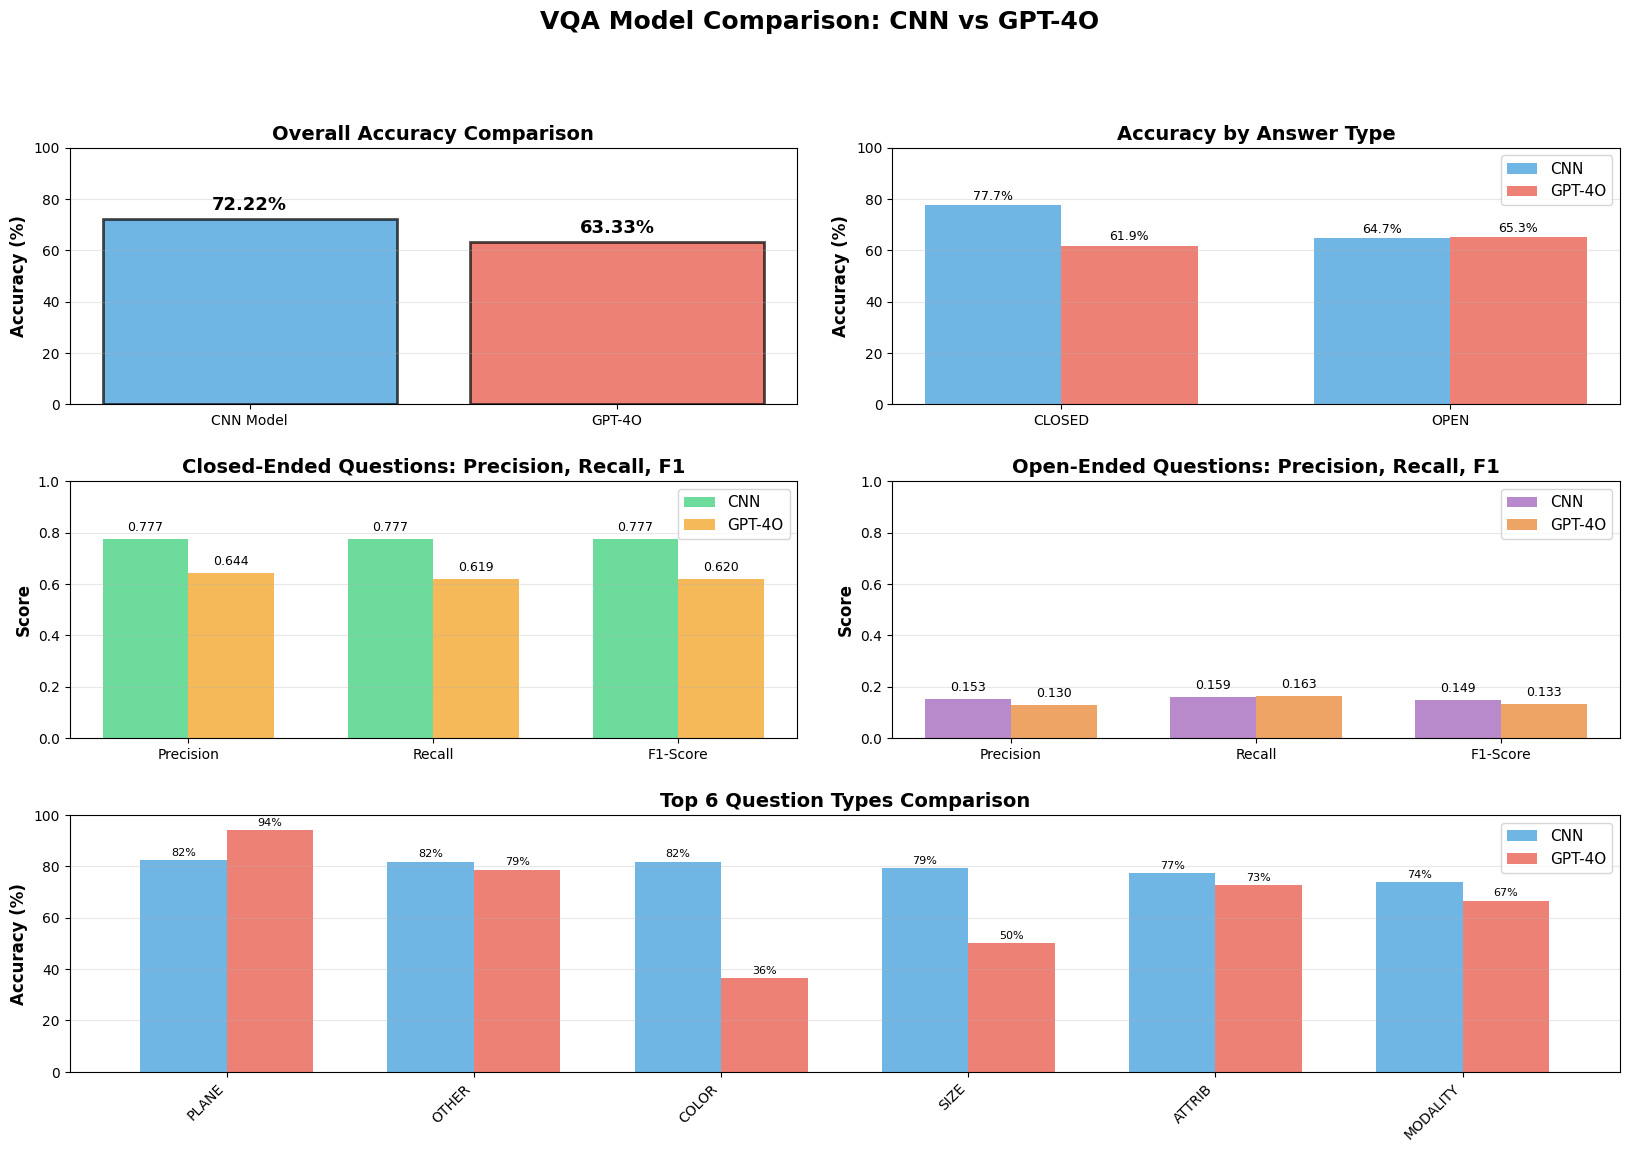

In [ ]:
def create_unified_comparison(cnn_results, gen_results, save_path='/content/drive/MyDrive/'):
    """Create unified comparison visualizations"""

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    # 1. Overall Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    models = ['CNN Model', 'GPT-4O']
    accuracies = [cnn_results['overall_accuracy'], gen_results['overall_accuracy']]
    colors = ['#3498db', '#e74c3c']
    bars = ax1.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 100])
    ax1.grid(axis='y', alpha=0.3)

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')

    # 2. Accuracy by Answer Type
    ax2 = fig.add_subplot(gs[0, 2:])
    answer_types = ['CLOSED', 'OPEN']
    x = np.arange(len(answer_types))
    width = 0.35

    cnn_type_accs = [cnn_results['type_metrics'][t]['accuracy'] for t in answer_types]
    gen_type_accs = [gen_results['type_metrics'][t]['accuracy'] for t in answer_types]

    bars1 = ax2.bar(x - width/2, cnn_type_accs, width, label='CNN', color='#3498db', alpha=0.7)
    bars2 = ax2.bar(x + width/2, gen_type_accs, width, label='GPT-4O', color='#e74c3c', alpha=0.7)

    ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy by Answer Type', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(answer_types)
    ax2.legend(fontsize=11)
    ax2.set_ylim([0, 100])
    ax2.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    # 3. Precision, Recall, F1 for CLOSED questions
    ax3 = fig.add_subplot(gs[1, :2])
    metrics_names = ['Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics_names))
    width = 0.35

    cnn_closed = cnn_results['type_metrics']['CLOSED']
    gen_closed = gen_results['type_metrics']['CLOSED']

    cnn_metrics = [cnn_closed['precision'], cnn_closed['recall'], cnn_closed['f1']]
    gen_metrics = [gen_closed['precision'], gen_closed['recall'], gen_closed['f1']]

    bars1 = ax3.bar(x - width/2, cnn_metrics, width, label='CNN', color='#2ecc71', alpha=0.7)
    bars2 = ax3.bar(x + width/2, gen_metrics, width, label='GPT-4O', color='#f39c12', alpha=0.7)

    ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax3.set_title('Closed-Ended Questions: Precision, Recall, F1', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics_names)
    ax3.legend(fontsize=11)
    ax3.set_ylim([0, 1])
    ax3.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 4. Precision, Recall, F1 for OPEN questions
    ax4 = fig.add_subplot(gs[1, 2:])

    cnn_open = cnn_results['type_metrics']['OPEN']
    gen_open = gen_results['type_metrics']['OPEN']

    cnn_metrics_open = [cnn_open['precision'], cnn_open['recall'], cnn_open['f1']]
    gen_metrics_open = [gen_open['precision'], gen_open['recall'], gen_open['f1']]

    bars1 = ax4.bar(x - width/2, cnn_metrics_open, width, label='CNN', color='#9b59b6', alpha=0.7)
    bars2 = ax4.bar(x + width/2, gen_metrics_open, width, label='GPT-4O', color='#e67e22', alpha=0.7)

    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.set_title('Open-Ended Questions: Precision, Recall, F1', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics_names)
    ax4.legend(fontsize=11)
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 5. Question Type Comparison (Top 6)
    ax5 = fig.add_subplot(gs[2, :])

    # Get common question types
    cnn_qtypes = set(cnn_results['question_metrics'].keys())
    gen_qtypes = set(gen_results['question_metrics'].keys())
    common_qtypes = sorted(list(cnn_qtypes & gen_qtypes),
                          key=lambda x: -cnn_results['question_metrics'][x]['accuracy'])[:6]

    x = np.arange(len(common_qtypes))
    width = 0.35

    cnn_qtype_accs = [cnn_results['question_metrics'][qt]['accuracy'] for qt in common_qtypes]
    gen_qtype_accs = [gen_results['question_metrics'][qt]['accuracy'] for qt in common_qtypes]

    bars1 = ax5.bar(x - width/2, cnn_qtype_accs, width, label='CNN', color='#3498db', alpha=0.7)
    bars2 = ax5.bar(x + width/2, gen_qtype_accs, width, label='GPT-4O', color='#e74c3c', alpha=0.7)

    ax5.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax5.set_title('Top 6 Question Types Comparison', fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(common_qtypes, rotation=45, ha='right')
    ax5.legend(fontsize=11)
    ax5.set_ylim([0, 100])
    ax5.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

    plt.suptitle('VQA Model Comparison: CNN vs GPT-4O', fontsize=18, fontweight='bold', y=0.995)

    save_file = os.path.join(save_path, 'unified_model_comparison.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    print(f"\n✓ Unified comparison saved to: {save_file}")
    plt.show()

# Create unified visualization
create_unified_comparison(cnn_results, gen_results)

# **Step 12: Comparison Table**

In [ ]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Closed Accuracy', 'Closed Precision', 'Closed Recall',
               'Closed F1', 'Open Accuracy', 'Open Precision', 'Open Recall', 'Open F1'],
    'CNN Model': [
        f"{cnn_results['overall_accuracy']:.2f}%",
        f"{cnn_results['type_metrics']['CLOSED']['accuracy']:.2f}%",
        f"{cnn_results['type_metrics']['CLOSED']['precision']:.4f}",
        f"{cnn_results['type_metrics']['CLOSED']['recall']:.4f}",
        f"{cnn_results['type_metrics']['CLOSED']['f1']:.4f}",
        f"{cnn_results['type_metrics']['OPEN']['accuracy']:.2f}%",
        f"{cnn_results['type_metrics']['OPEN']['precision']:.4f}",
        f"{cnn_results['type_metrics']['OPEN']['recall']:.4f}",
        f"{cnn_results['type_metrics']['OPEN']['f1']:.4f}"
    ],
    'GPT-4O Model': [
        f"{gen_results['overall_accuracy']:.2f}%",
        f"{gen_results['type_metrics']['CLOSED']['accuracy']:.2f}%",
        f"{gen_results['type_metrics']['CLOSED']['precision']:.4f}",
        f"{gen_results['type_metrics']['CLOSED']['recall']:.4f}",
        f"{gen_results['type_metrics']['CLOSED']['f1']:.4f}",
        f"{gen_results['type_metrics']['OPEN']['accuracy']:.2f}%",
        f"{gen_results['type_metrics']['OPEN']['precision']:.4f}",
        f"{gen_results['type_metrics']['OPEN']['recall']:.4f}",
        f"{gen_results['type_metrics']['OPEN']['f1']:.4f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"✓ Best CNN Model saved to: {best_model_path}")
print(f"✓ Best CNN Validation Accuracy: {best_val_acc:.2f}%")
print(f"✓ All visualizations saved to: /content/drive/MyDrive/")


FINAL MODEL COMPARISON SUMMARY

          Metric CNN Model GPT-4O Model
Overall Accuracy    72.22%       63.33%
 Closed Accuracy    77.69%       61.92%
Closed Precision    0.7769       0.6440
   Closed Recall    0.7769       0.6192
       Closed F1    0.7769       0.6202
   Open Accuracy    64.74%       65.26%
  Open Precision    0.1529       0.1300
     Open Recall    0.1591       0.1633
         Open F1    0.1485       0.1332

TRAINING COMPLETE!
✓ Best CNN Model saved to: /content/drive/MyDrive/best_vqa_model_enhanced.pth
✓ Best CNN Validation Accuracy: 72.22%
✓ All visualizations saved to: /content/drive/MyDrive/
